**Implementing SimCLR using TensorFlow**

In [18]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [19]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

  Using cached https://github.com/wandb/client/archive/feature/code-save.zip


In [20]:
import wandb
wandb.login()

True

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

**Using Imagenet Dataset**

In [22]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [23]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


**Data Augmentation**

In [24]:
class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [25]:
data_augmentation = Sequential([Lambda(CustomAugment())])# Build the augmentation pipeline

In [26]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [27]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Similarity Score function

In [28]:
# helper classes from https://github.com/sthalles/

def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)


def gaussian_filter(v1, v2):
    k_size = int(v1.shape[1] * 0.1)  # kernel size is set to be 10% of the image height/width
    gaussian_ope = GaussianBlur(kernel_size=k_size, min=0.1, max=2.0)
    [v1, ] = tf.py_function(gaussian_ope, [v1], [tf.float32])
    [v2, ] = tf.py_function(gaussian_ope, [v2], [tf.float32])
    return v1, v2

In [29]:
# losses from https://github.com/sthalles/

cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def sim_func_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def sim_func_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

In [30]:
negative_mask = get_negative_mask(BATCH_SIZE)
print(negative_mask)

tf.Tensor(
[[False  True  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 [ True  True False ...  True  True  True]
 ...
 [ True  True  True ... False  True  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True  True False]], shape=(64, 128), dtype=bool)


**Model using Resnet50, dense layers and projection head**

In [31]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

**Training the model**

In [32]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [33]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

**Plot**

 10%|█         | 1/10 [27:55<4:11:15, 1675.09s/it]

epoch: 1 loss: 4.773


100%|██████████| 10/10 [4:41:37<00:00, 1689.74s/it]


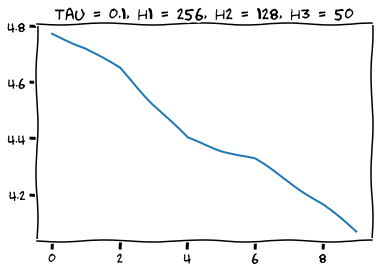

In [34]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=10)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()